<a href="https://colab.research.google.com/github/fawniechau/Water-Quality/blob/main/chau_well_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This project follows an analysis of a public health study performed in rural Bangladesh (Gelman et al. 2004). In this study, wells used for drinking water were analyzed for arsenic contamination and correspondingly labeled as safe or unsafe. The study determined whether households switched the well used for drinking water. Additionally, several variables where measured that were thought to possibly influence the decision of whether or not to switch wells. Here, we will investigate how accurately we can predict whether or not a household will switch wells based on these environmental variables.

See Gelman et al. (2004) for a discussion of data collection. Briefly, arsenic levels (in hundreds $\mu$g/L) were measured in Araihazar, Bangladesh during the years 1999 - 2000. Additional information was collected by a survey:

1. Whether or not the household switched wells.

2. The distance (in meters) to the closest known safe well.

3. Whether any members of the household are involved in community organizations.

4. The highest education level in the household.


## Import libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import missingno as msno

# plot tree model
import graphviz

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix

# Model metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from scipy.stats import uniform, randint


# Logistic function
from scipy.special import expit

## Load the data

$\rightarrow$ Load the data set contained in the file `wells.csv` and name the data frame `df`.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/brian-fischer/DATA-3320/main/wells.csv')

## Explore the contents of the data sets

$\rightarrow$ Look at the head of the data frame.


In [4]:
df.describe()

,switch,arsenic,dist,assoc,educ
count,3020.000000,3020.000000,3020.000000,3020.000000,3020.000000
mean,0.575166,1.656930,48.331863,0.422848,4.828477
std,0.494400,1.107387,38.478675,0.494093,4.017317
min,0.000000,0.510000,0.387000,0.000000,0.000000
25%,0.000000,0.820000,21.117250,0.000000,0.000000
50%,1.000000,1.300000,36.761499,0.000000,5.000000
75%,1.000000,2.200000,64.041000,1.000000,8.000000
max,1.000000,9.650000,339.531006,1.000000,17.000000


In [5]:
df.head()

,switch,arsenic,dist,assoc,educ
0,1,2.36,16.826000,0,0
1,1,0.71,47.321999,0,0
2,0,2.07,20.966999,0,10
3,1,1.15,21.486000,0,12
4,1,1.10,40.874001,1,14


The variables in the data set are:

1. `switch`: An indicator of whether a household switches wells.

2. `arsenic`: The arsenic level of the household's well (in hundreds $\mu$g/L).

3. `dist`: The distance (in meters) to the closest known safe well.

4. `assoc`: An indicator of whether any members of the household are involved in community organizations.

5. `educ`: The highest education level in the household.
  
  

In [8]:
# retrieves unique values from "assoc"
df['assoc'].unique()

array([0, 1])

In [9]:
# compute frequency count for each unique value 
df['assoc'].value_counts()

0    1743
1    1277
Name: assoc, dtype: int64

$\rightarrow$ Let's check for data types and see if there's any missing data in this data set.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   switch   3020 non-null   int64  
 1   arsenic  3020 non-null   float64
 2   dist     3020 non-null   float64
 3   assoc    3020 non-null   int64  
 4   educ     3020 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 118.1 KB


<Axes: >

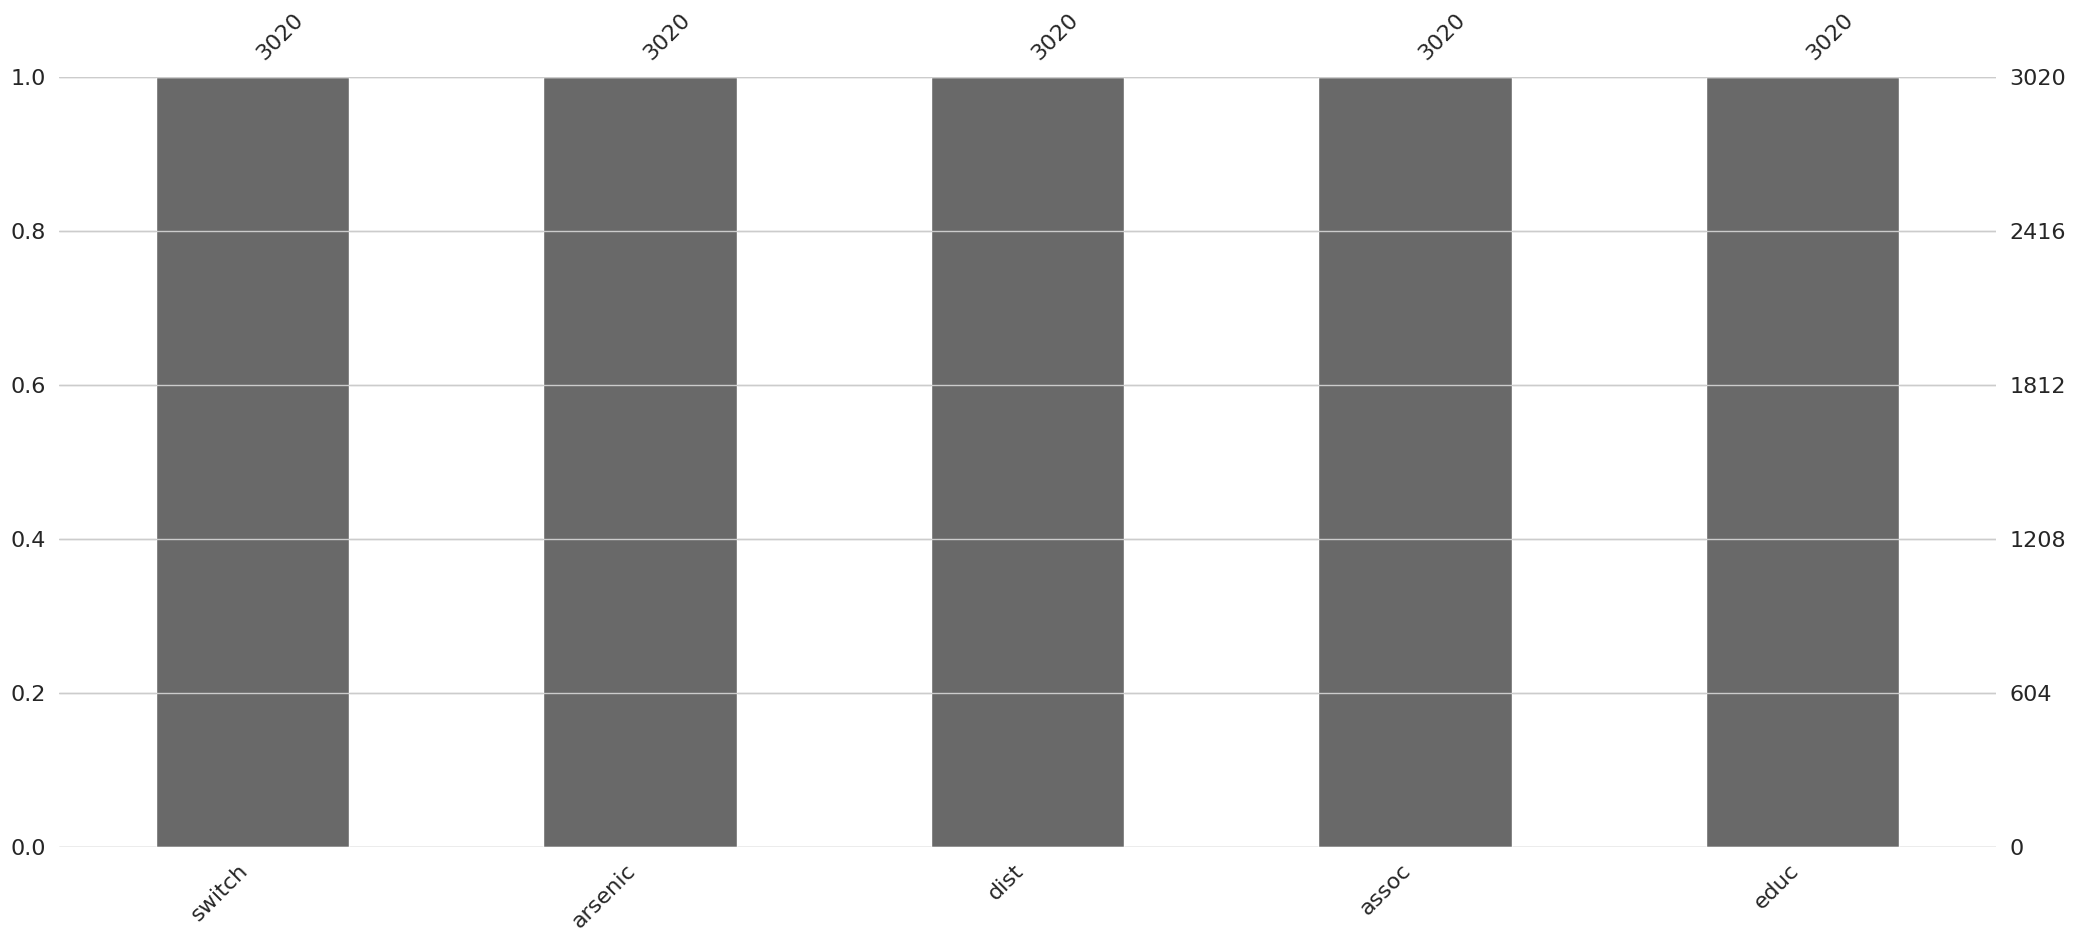

In [11]:
msno.bar(df)

There are no missing values and the data types seem fine.

## Are the data suitable for answering the question?

We want to perform quick exploratory data analysis to determine whether the data are sufficient to answer our question. Let's do a pairplot to visually see different variables together. 

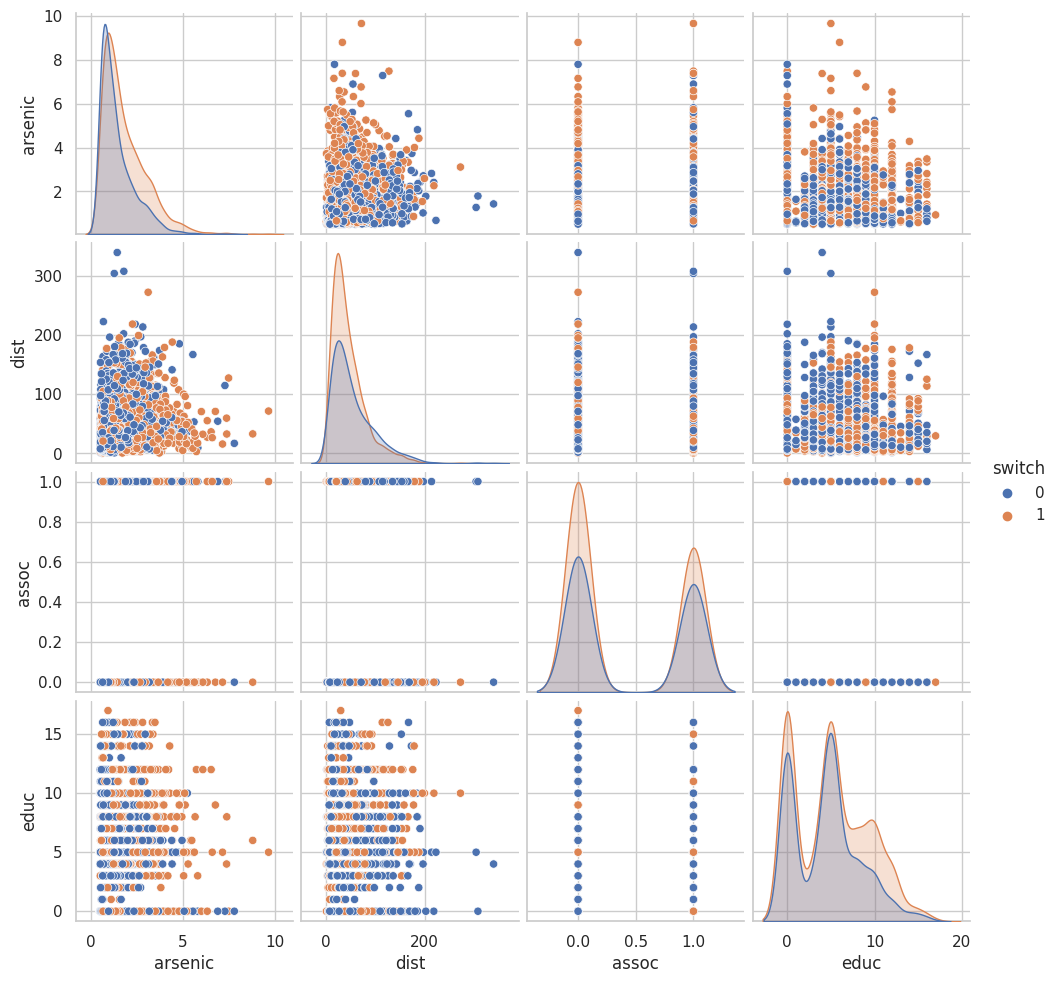

In [12]:
sns.pairplot(df, hue='switch');

Based on the result array([0, 1]), it appears that the 'assoc' column contains two unique values: 0 and 1. This suggests that there is a reasonable balance between switching (represented by 1) and not switching (represented by 0).

The presence of both switching and not switching values indicates that there is variability in the 'assoc' column, and it's likely that there is some relationship between switching and other variables in this dataset.

## Rename columns or values to follow best practices

In [13]:
df.columns

Index(['switch', 'arsenic', 'dist', 'assoc', 'educ'], dtype='object')

In [16]:
# rename column names 
df.rename(columns={'switch':'switch_well', 
                   'dist':'distance_in_meters', 
                   'assoc':'organization_member', 
                   'educ':'education_years'}, inplace=True)

In [15]:
df.head()

,switch_well,arsenic,distance_in_meters,organization_member,education_years
0,1,2.36,16.826000,0,0
1,1,0.71,47.321999,0,0
2,0,2.07,20.966999,0,10
3,1,1.15,21.486000,0,12
4,1,1.10,40.874001,1,14


## Create relevant derived variables as new columns

We may already know that we want to process the data to create new variables from the existing variables. However, we often start analyzing the data and realize that it is useful to create new variables derived from the existing variables. It is fine to return to modify this step after exploring the data further.

It is difficult to interpret the coefficient on `distance` in models using it as a predictor because distance is measured in meters. We don't expect much of a change in switching behavior for wells that are 1 meter apart. A more natural measure is 100s of meters. We will scale the distance variable to be in units of 100s of meters.

$\rightarrow$ Here we are converting the distance units into 100s of meters by creating a new column.


In [17]:
df['distance_100_meters'] = df['distance_in_meters']/100

In [18]:
df.head()

,switch_well,arsenic,distance_in_meters,organization_member,education_years,distance_100_meters
0,1,2.36,16.826000,0,0,0.16826
1,1,0.71,47.321999,0,0,0.47322
2,0,2.07,20.966999,0,10,0.20967
3,1,1.15,21.486000,0,12,0.21486
4,1,1.10,40.874001,1,14,0.40874


# Analysis

## Exploratory data analysis

We have two main goals when doing exploratory data analysis. The first is that we want to understand the data set more completely. The second goal is to explore relationships between the variables to help guide the modeling process to answer our specific question.


##### $\rightarrow$ How many switches and non-switches are in the data set?

In [19]:
df['switch_well'].value_counts()

1    1737
0    1283
Name: switch_well, dtype: int64

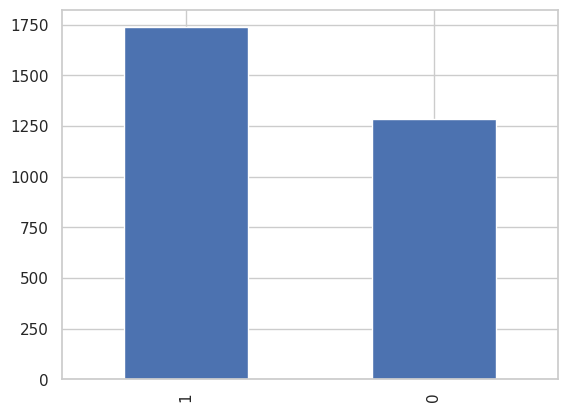

In [20]:
df['switch_well'].value_counts().plot(kind='bar');



We want to investigate whether the probability of switching wells is a clear function of the input numerical variables. 




Plot for the `arsenic` concentration vs. the `switch_well` variable.

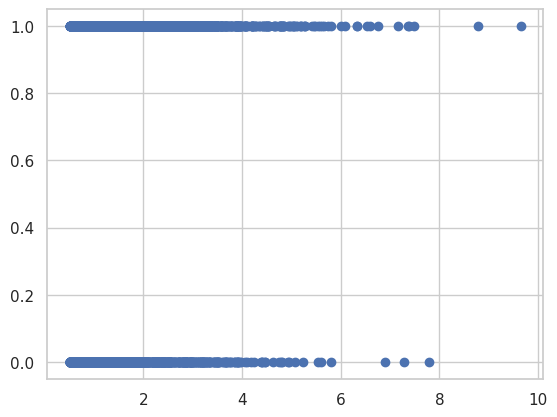

In [23]:
# arsenic vs. switch_well
plt.plot(df['arsenic'], df['switch_well'],'o')

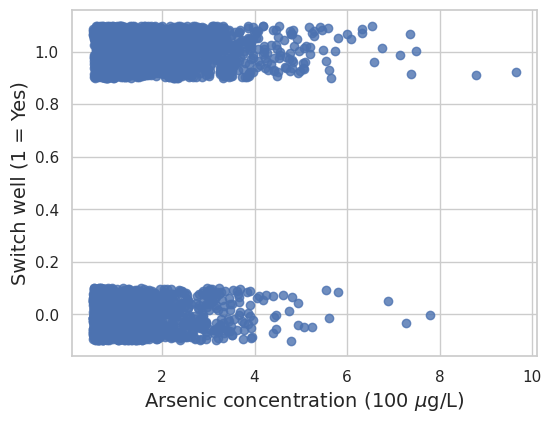

In [24]:
# arsenic vs. switch_well
plt.figure(figsize = (6,4.5))

sns.regplot(data = df, x = 'arsenic', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1)

plt.xlabel('Arsenic concentration (100 $\mu$g/L)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Plot for the distance to the nearest well (in 100 meters) vs. the `switch_well` variable.

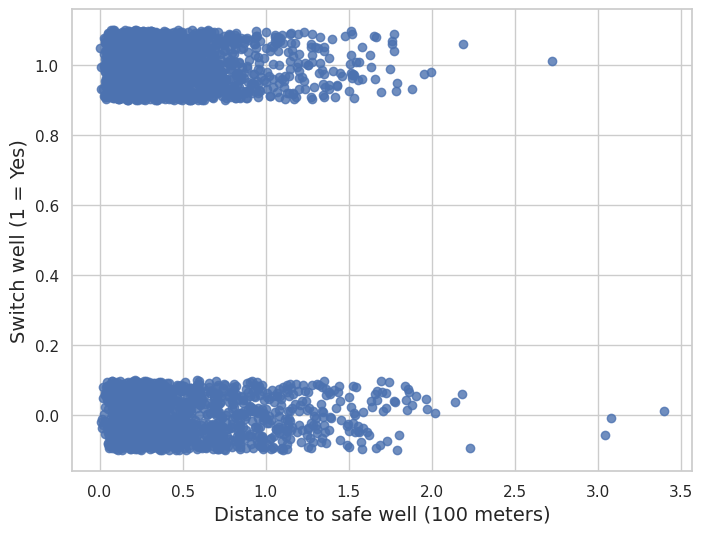

In [25]:
# distance to nearest well vs. switch_well
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'distance_100_meters', y = 'switch_well', ci = None, fit_reg=False, y_jitter = 0.1)

plt.xlabel('Distance to safe well (100 meters)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Plot for years of education vs. the `switch_well` variable.

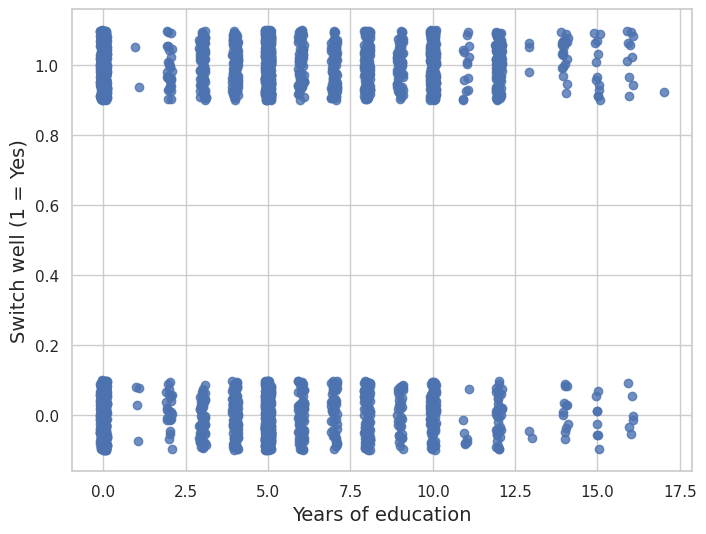

In [26]:
# education_years vs. switch_well
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'education_years', y = 'switch_well', 
            ci = None, fit_reg=False, y_jitter = 0.1,  x_jitter = 0.1)

plt.xlabel('Years of education', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

$\rightarrow$ Here is the count for the number of switches for each value of `organization_member`, as well as the proportion of switches for each value of `organization_member`.


In [28]:
# groups columns and calculates aggregate
df[['switch_well', 'organization_member']].groupby('organization_member').agg(['sum', 'mean'])

switch_well          
                            sum      mean
organization_member                      
0                          1029  0.590361
1                           708  0.554424

## Modeling

Note that linear regression does not produce a suitable model when the output variable is binary.

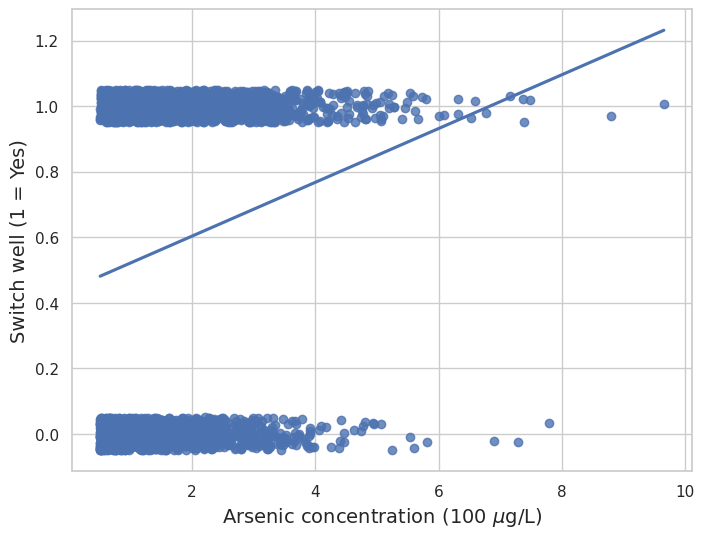

In [29]:
# arsenic vs. switch_well
plt.figure(figsize = (8,6))

sns.regplot(data = df, x = 'arsenic', y = 'switch_well', ci = None, y_jitter = 0.05)

plt.xlabel('Arsenic concentration (100 $\mu$g/L)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

Based on the provided information, it appears that there is an equal number of people who are hesitant to switch compared to those who did switch, despite the lower arsenic concentration observed between values 0 and 4.

This suggests that the decision to switch or not switch is not solely determined by the arsenic concentration. Other factors or variables might be influencing the decision-making process. 

### Exploratory models

We will build models using the full data set to understand it more completely.

#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the full data set.

In [30]:
X = df.drop(columns=['switch_well', 'distance_in_meters'])

y = df['switch_well']

In [31]:
X.head()

,arsenic,organization_member,education_years,distance_100_meters
0,2.36,0,0,0.16826
1,0.71,0,0,0.47322
2,2.07,0,10,0.20967
3,1.15,0,12,0.21486
4,1.10,1,14,0.40874


In [34]:
# doing a logistic regression using the Logit function 
log_reg_all = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.646991
         Iterations 5


With a value of 0.646991, it suggests that the model has achieved a reasonably good fit to the data. However, there may still be room for improvement, as a lower value of the objective function would indicate a better fit.

In [35]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3015
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                 0.05106
Time:                        19:40:48   Log-Likelihood:                -1953.9
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 2.321e-44
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1567      0.100     -1.573      0.116      -0.352       0.039
arsenic                 0.4670      0.042     11.226      0.000       0.385       0.549
organization_mem

It looks like all predictors besides `const` and `organization_member` are statistically significant. 

##### $\rightarrow$ Predict the well switching in the data

In [41]:
# making predictions with log regression model
log_reg_all.predict(sm.add_constant(X))

0       0.688835
1       0.438024
2       0.740122
3       0.667563
4       0.613178
          ...   
3015    0.500176
3016    0.539684
3017    0.545420
3018    0.516202
3019    0.513165
Length: 3020, dtype: float64

In [42]:
# rounding predicted values to obtain binary predictions
pred_switch = round(log_reg_all.predict(sm.add_constant(X)))

In [38]:
pred_switch

0       1.0
1       0.0
2       1.0
3       1.0
4       1.0
       ... 
3015    1.0
3016    1.0
3017    1.0
3018    1.0
3019    1.0
Length: 3020, dtype: float64

##### $\rightarrow$ Show the confusion matrix to visualize the errors.

In [39]:
class_names = ['no switch', 'switch']

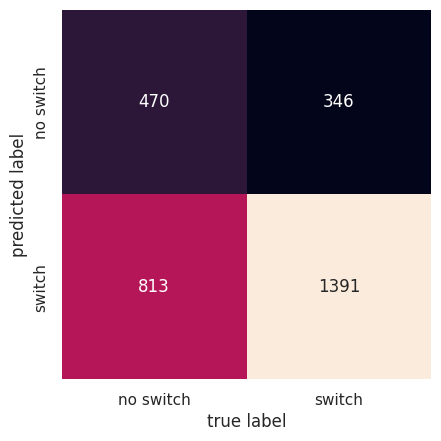

In [43]:
# heatmap visualization 
sns.heatmap(confusion_matrix(y, pred_switch).T, square=True, annot=True, cbar=False, 
            fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [44]:
confusion_matrix(y, pred_switch).T

array([[ 470,  346],
       [ 813, 1391]])

In [45]:
print(classification_report(y, pred_switch, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.58      0.37      0.45      1283
      switch       0.63      0.80      0.71      1737

    accuracy                           0.62      3020
   macro avg       0.60      0.58      0.58      3020
weighted avg       0.61      0.62      0.60      3020



The model achieved an overall accuracy of 62%.

Regarding the "no switch" class:
* Precision is 0.58. This indicates that 58% of the predicted "no switch" instances were actually true.
* Recall is 0.37. This means that 37% of the true "no switch" instances were correctly identified by the model.
* F1-score is 0.45. The F1-score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.
* Support is 1283. The number of instances in the "no switch" class in the dataset.

Regarding the "switch" class:
* Precision is 0.63. The model correctly identified 63% of the predicted "switch" instances.
* Recall is 0.80.The model accurately captured 80% of the true "switch" instances.
* F1-score is 0.71. The F1-score for the "switch" class indicates a reasonably balanced performance between precision and recall.
* Support is 1737. The number of instances in the "switch" class in the dataset.

In [48]:
# calculating recall for "no switch" class 
470/(470+813)

0.36632891660171474

In [50]:
# calculating precision for "switch" class
1391/(1391+346)

0.8008059873344847

A precision value of 0.801 indicates that around 80.1% of the instances predicted as "switch" by the model are actually correct.

#### Null model

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ The null model prediction for `switch_well`?





In [53]:
null_prediction = np.ones(np.shape(y))

$\rightarrow$ What is the accuracy of the null model on the full data set?


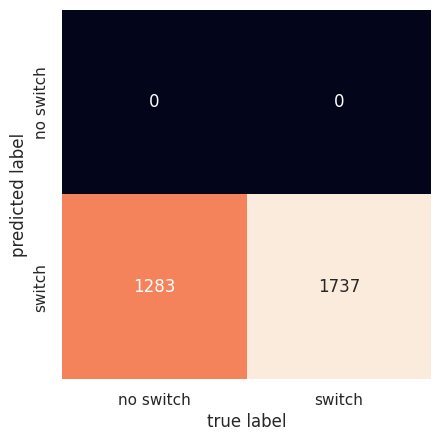

In [54]:
sns.heatmap(confusion_matrix(y, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [55]:
print(classification_report(y, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.00      0.00      0.00      1283
      switch       0.58      1.00      0.73      1737

    accuracy                           0.58      3020
   macro avg       0.29      0.50      0.37      3020
weighted avg       0.33      0.58      0.42      3020



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model achieved an overall accuracy of 58%.

No switch is 0 across the board except for the support value of 1283. 

Regarding the "switch" class:
* Precision is 0.58. The model correctly identified 58% of the predicted "switch" instances.
* Recall is 1.00. The model accurately captured 100% of the true "switch" instances.
* F1-score is 0.73. The F1-score for the "switch" class indicates a reasonably balanced performance between precision and recall.
* Support is 1737. The number of instances in the "switch" class in the dataset.

### Simple logistic regression models

#### Fit a model with distance as the predictor




$\rightarrow$ Fit a logistic regression model with distance (in 100s of meters) as the predictor and examine the model.

In [56]:
X = df[['distance_100_meters']]

y = df['switch_well']

In [57]:
log_reg_distance = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4


In [58]:
print(log_reg_distance.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                 0.01017
Time:                        19:58:47   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.6060      0.060     10.047      0.000       0.488       0.724
distance_100_meters    -0.6219      0.097     -6.383      0.000      -0.813      -0.431


Low p-value of 0.00 suggests statistical significance for both const and distance_100_meters

$\rightarrow$ Plot for the distance to the nearest well (in 100 meters) vs. the `switch_well` variable and including the logistic regression model.

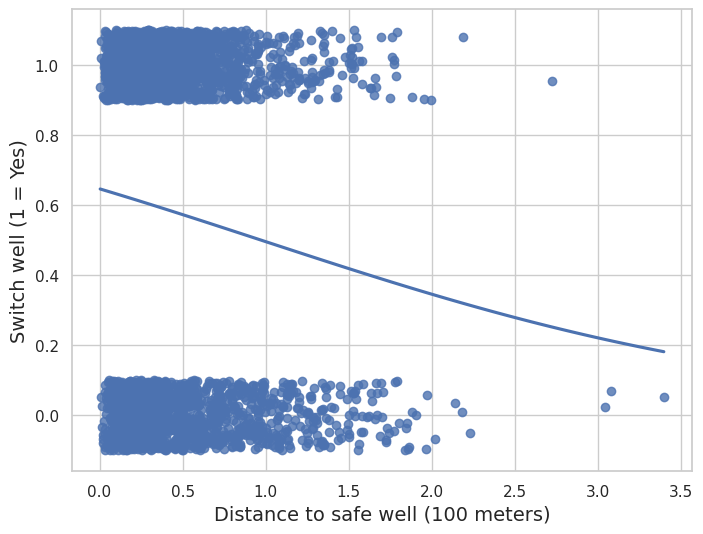

In [59]:
plt.figure(figsize = (8,6))

sns.regplot(data = df, 
            x = 'distance_100_meters', y = 'switch_well', 
            ci = None, y_jitter = 0.1, logistic=True)

plt.xlabel('Distance to safe well (100 meters)', fontsize = 14)
plt.ylabel('Switch well (1 = Yes)', fontsize = 14);

In [60]:
# calculates estimated change with coefficient for distance
-.6219/4

-0.155475

In [61]:
# calculates estimated probability of "switch_well"
1/(1 + np.exp(-.606))

0.6470278089459086

In [62]:
# logistic transformation to const coefficient
expit(0.606)

0.6470278089459086

64.7% probability of the "switch_well" outcome occurring,

$\rightarrow$ Interpret the value of $\hat{\beta}_0$.


The estimated probability $$P(\text{switch_well} = 1|\text{distance} = 0) = \frac{1}{1 + e^{-\hat{\beta}_0}} = \frac{1}{1 + e^{-0.61}} = 0.65$$


The estimated probability of switching wells if the nearest safe well is where you live is 65%.


$\rightarrow$ Interpret the value of $\hat{\beta}_1$ by discussing its sign and what it says about the maximum rate of change of the probability of switching.


$\hat{\beta}_1 < 0$, so an increase in distance to the nearest safe well is associated with a decrease in probability of switching wells.


The maximum rate of change of the probability of switching is

$$\frac{\hat{\beta}_1}{4} = \frac{-0.62}{4} = -0.155$$
At the point of maximum rate of change of the probability of switching, a 100 meter increase in the distance to the nearest safe well corresponds to a decrease in probability of switching of about 16%

##### $\rightarrow$ Predicting the well switching in the data

In [63]:
pred_switch_distance = round(log_reg_distance.predict(sm.add_constant(X)))

##### $\rightarrow$ The confusion matrix to visualize the errors.

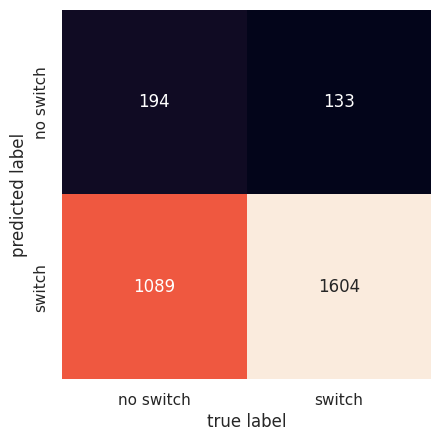

In [64]:
sns.heatmap(confusion_matrix(y, pred_switch_distance).T, square=True, annot=True, 
            cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [65]:
print(classification_report(y, pred_switch_distance, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.59      0.15      0.24      1283
      switch       0.60      0.92      0.72      1737

    accuracy                           0.60      3020
   macro avg       0.59      0.54      0.48      3020
weighted avg       0.59      0.60      0.52      3020



The overall accuracy of the model on the test data was 0.60, indicating that it correctly classified 60% of the instances.

Regarding the "no switch" class:
* Precision: The model achieved a precision of 0.59, indicating that when it predicted "no switch," it was correct 59% of the time.
* Recall: The model had a recall of 0.15, meaning that it only identified 15% of the actual "no switch" instances correctly.
* F1-score: The F1-score for the "no switch" class was 0.24, which is a measure of the model's balance between precision and recall. It indicates that the model's performance in correctly identifying the "no switch" class is relatively low.
* Support: The "no switch" class had a total of 1283 instances in the test data.

Regarding the "switch" class:
* Precision: The model achieved a precision of 0.60 for the "switch" class, indicating that it accurately predicted "switch" 60% of the time.
* Recall: The model had a recall of 0.92 for the "switch" class, indicating that it successfully identified 92% of the actual "switch" instances.
* F1-score: The F1-score for the "switch" class was 0.72, indicating a relatively good balance between precision and recall for this class.
* Support: The "switch" class had a total of 1737 instances in the test data.

#### Fit a model with distance and arsenic as predictors

Fit the model and examine the coefficients.


In [66]:
X = df[['distance_100_meters', 'arsenic']]

In [67]:
log_reg_distance_arsenic = sm.Logit(y, sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5


In [68]:
print(log_reg_distance_arsenic.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                 0.04551
Time:                        20:09:36   Log-Likelihood:                -1965.3
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.995e-41
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0027      0.079      0.035      0.972      -0.153       0.158
distance_100_meters    -0.8966      0.104     -8.593      0.000      -1.101      -0.692
arsenic         

All predictors except for const are statistically significant. The pseudo R-squared value of 0.045 indicating that this is a poor model overall. 


$\rightarrow$ Why did the coefficient for `distance` change when arsenic was added?


There is a high correlation between distance and arsenic concentration.

$\rightarrow$ Plot for the decision boundary on a scatter plot of distance vs. arsenic, with point colored by switch.

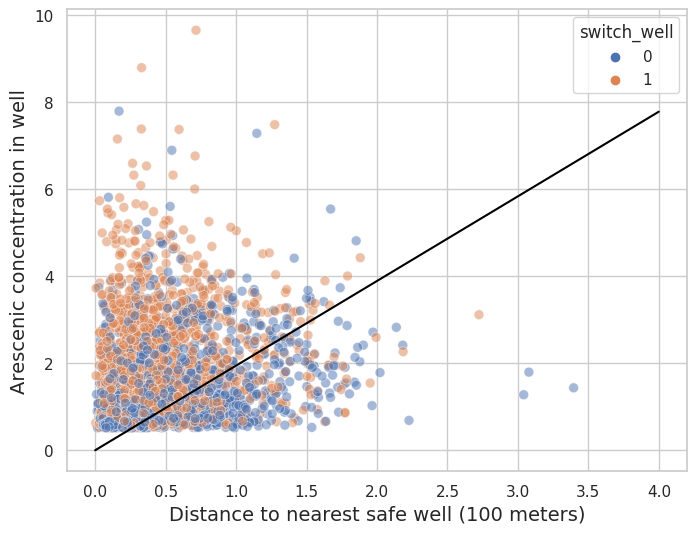

In [70]:
plt.figure(figsize = (8,6))

sns.scatterplot(data = df, x = 'distance_100_meters', y = 'arsenic', hue = 'switch_well', alpha = 0.5, s = 50);


a, b, c = log_reg_distance_arsenic.params.values
x_boundary = np.linspace(0,4,100)
y_boundary = (-a - b*x_boundary)/c

plt.plot(x_boundary, y_boundary, color = 'black')

plt.xlabel('Distance to nearest safe well (100 meters)', fontsize = 14)
plt.ylabel('Arescenic concentration in well', fontsize = 14);

The farther they live, the less they are willing to switch wells as indicated by the blue plots.

##### $\rightarrow$ Predicting the well switching in the data

In [71]:
pred_switch_distance_arsenic = round(log_reg_distance_arsenic.predict(sm.add_constant(X)))

##### $\rightarrow$ The confusion matrix to visualize the errors.

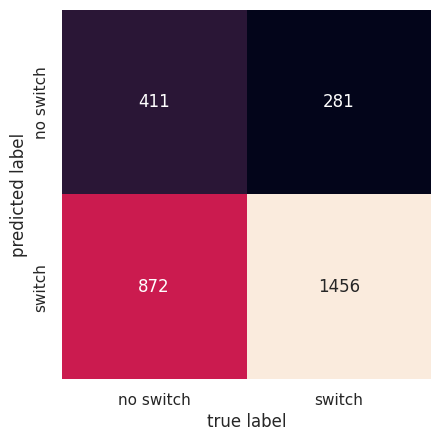

In [72]:
sns.heatmap(confusion_matrix(y, pred_switch_distance_arsenic).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy.

In [73]:
print(classification_report(y, pred_switch_distance_arsenic, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.59      0.32      0.42      1283
      switch       0.63      0.84      0.72      1737

    accuracy                           0.62      3020
   macro avg       0.61      0.58      0.57      3020
weighted avg       0.61      0.62      0.59      3020



In [74]:
print(classification_report(y, pred_switch, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.58      0.37      0.45      1283
      switch       0.63      0.80      0.71      1737

    accuracy                           0.62      3020
   macro avg       0.60      0.58      0.58      3020
weighted avg       0.61      0.62      0.60      3020



## Compare models

We will use logistic regression and XGBoost to construct models that predict the probability of switching wells.

To compare the different approaches, we will use a training and testing split of the data set.


##### $\rightarrow$ Create an input $X$ with all predictors.

In [75]:
X = df.drop(columns=['switch_well', 'distance_in_meters'])
y = df['switch_well']

In [76]:
X.head()

,arsenic,organization_member,education_years,distance_100_meters
0,2.36,0,0,0.16826
1,0.71,0,0,0.47322
2,2.07,0,10,0.20967
3,1.15,0,12,0.21486
4,1.10,1,14,0.40874


##### $\rightarrow$ Splitting the data into training and testing sets. Keep 20% of the data for the test set.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [78]:
print(X_train.shape, X_test.shape)

(2416, 4) (604, 4)


##### $\rightarrow$ Checking that the training and testing input numerical variables have similar means and standard deviations.

In [79]:
X_train.agg(['mean','std']).round(2)

,arsenic,organization_member,education_years,distance_100_meters
mean,1.68,0.43,4.84,0.49
std,1.12,0.49,4.02,0.39


In [80]:
X_test.agg(['mean','std']).round(2)

,arsenic,organization_member,education_years,distance_100_meters
mean,1.58,0.41,4.77,0.47
std,1.04,0.49,4.02,0.38


In [81]:
y_train.value_counts()

1    1392
0    1024
Name: switch_well, dtype: int64

In [82]:
y_test.value_counts()

1    345
0    259
Name: switch_well, dtype: int64

In [83]:
y_train.mean()

0.5761589403973509

In [84]:
y_test.mean()

0.5711920529801324

### Null model 

The null model prediction always predicts the value of `switch_well` that occurs most often in the training data.


$\rightarrow$ Null model prediction for `switch_well` based on the training data


In [85]:
null_prediction = np.ones(np.shape(y_test))

In [86]:
y_train.value_counts()

1    1392
0    1024
Name: switch_well, dtype: int64

$\rightarrow$ What is the accuracy of the null model on the test data set?


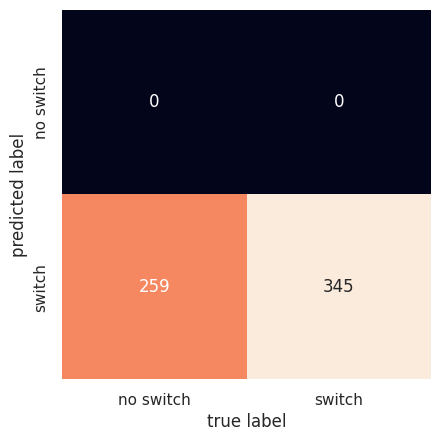

In [87]:
sns.heatmap(confusion_matrix(y_test, null_prediction).T, square=True, annot=True, cbar=False, fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [88]:
print(classification_report(y_test, null_prediction, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.00      0.00      0.00       259
      switch       0.57      1.00      0.73       345

    accuracy                           0.57       604
   macro avg       0.29      0.50      0.36       604
weighted avg       0.33      0.57      0.42       604



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The null prediction model performed poorly in terms of classification on the provided test data.The accuracy of the model is 57%, indicating that it correctly predicted the class label for 57% of the instances.

* The precision, recall, and f1-score for the "not_switched" class are all 0, indicating that the model failed to correctly identify any instances belonging to this class.
* The precision for the "switch" class is 57%, suggesting that the model was able to identify some instances of this class correctly.
* However, the recall and f1-score for the "switch" class are both 100%, indicating that the model may have incorrectly labeled some instances as belonging to this class.


### Logistic regression model


#### Logistic regression model for all predictors

##### $\rightarrow$ Fit the logistic regression model using all predictors, using the training data.

In [89]:
log_reg_all = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.643453
         Iterations 5


In [90]:
print(log_reg_all.summary())

                           Logit Regression Results                           
Dep. Variable:            switch_well   No. Observations:                 2416
Model:                          Logit   Df Residuals:                     2411
Method:                           MLE   Df Model:                            4
Date:                Tue, 06 Jun 2023   Pseudo R-squ.:                 0.05583
Time:                        20:16:23   Log-Likelihood:                -1554.6
converged:                       True   LL-Null:                       -1646.5
Covariance Type:            nonrobust   LLR p-value:                 1.110e-38
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1654      0.112     -1.479      0.139      -0.385       0.054
arsenic                 0.4782      0.046     10.307      0.000       0.387       0.569
organization_mem

##### $\rightarrow$ Predicting the well switching in the test data.

In [91]:
pred_switch_log_reg = round(log_reg_all.predict(sm.add_constant(X_test)))

##### $\rightarrow$ The confusion matrix to visualize the errors.

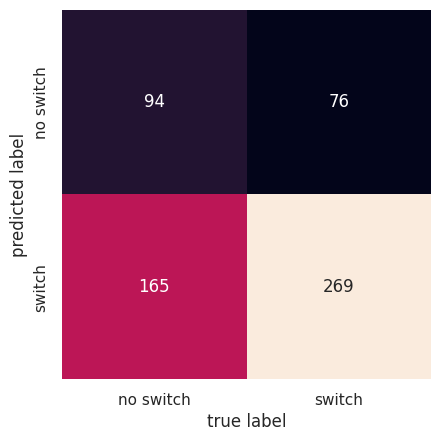

In [92]:
sns.heatmap(confusion_matrix(y_test, pred_switch_log_reg).T, 
            square=True, annot=True, cbar=False, fmt='g', 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Computing the model accuracy, sensitivity, and specificity.

In [93]:
print(classification_report(y_test, pred_switch_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The logistic regression model achieved an accuracy of 60%.

For the "no switch" class:
* The precision was 55%, indicating that 55% of the instances predicted as "no switch" were actually correct.
* The recall was 36%, implying that only 36% of the actual "no switch" instances were correctly identified.
* The f1-score was 0.44, representing the harmonic mean of precision and recall for the "no switch" class.

For the "switch" class:
* The precision was 62%, suggesting that 62% of the instances predicted as "switch" were correct.
* The recall was 78%, indicating that 78% of the actual "switch" instances were correctly identified.
* The f1-score was 0.69, representing the harmonic mean of precision and recall for the "switch" class.

### XGBoost


Comparing the model accuracy to an XGBoost model on the same train/test split.

$\rightarrow$ Using 5-fold cross-validation to determine the hyperparameters of the XGBoost model.


In [94]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),  
    "max_depth": randint(2, 6), 
    "n_estimators": randint(100, 150), 
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, 
                            n_iter=200, cv=5, verbose=1, 
                            n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f09507e21a0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09507e2ec0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f09507e4850>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f09507e1390>},
                   return_train_score=True, verbose=1)

$\rightarrow$ Fit the model using the best parameters on the training data.

In [95]:
search.best_params_

{'colsample_bytree': 0.7410607975393823,
 'gamma': 0.4529021983699458,
 'learning_rate': 0.03921881597943199,
 'max_depth': 2,
 'n_estimators': 126,
 'subsample': 0.7723782173667477}

In [122]:
# setting parameters of XGBoost to the best parameters
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7410607975393823, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4529021983699458, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03921881597943199, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=126, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [123]:
# fit the XGBoost model to training data 
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7410607975393823, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4529021983699458, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03921881597943199, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=126, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

##### $\rightarrow$ Plotting the feature importances using `gain` to determine importance.

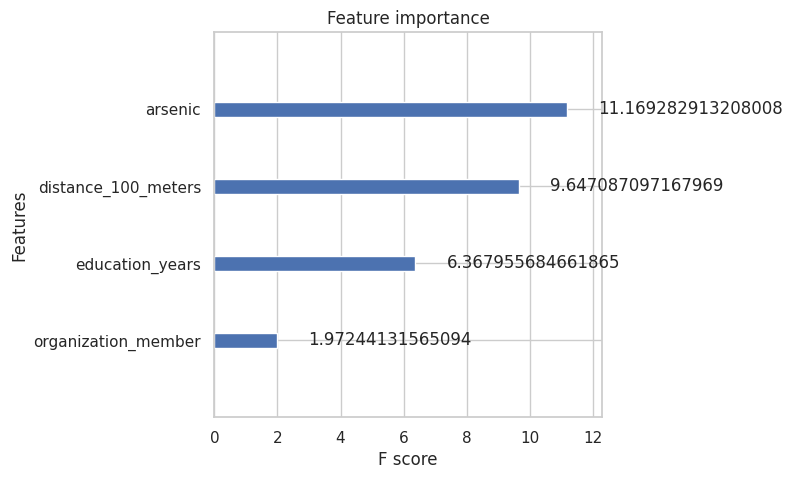

In [99]:
fig, ax = plt.subplots(figsize = (5,5))
xgb.plot_importance(xgb_model, ax = ax, importance_type='gain');

Arsenic has the highest feature importance value with 11.169. This idicates that changes to arsenic have the most impact on predictions made in the XGBoost model.

##### $\rightarrow$ Predicting the well switching in the test data.

In [100]:
pred_mgb = xgb_model.predict(X_test)

##### $\rightarrow$ The confusion matrix to visualize the errors.

In [101]:
mat_mgb = confusion_matrix(y_test, pred_mgb)

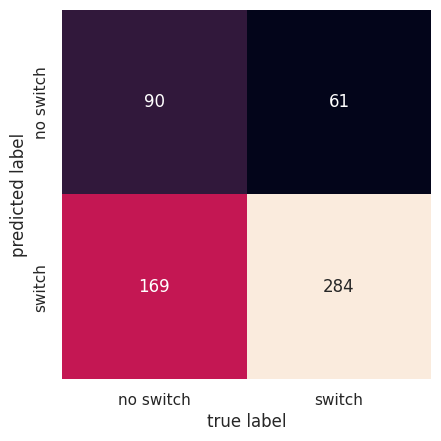

In [102]:
sns.heatmap(mat_mgb.T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('true label')
plt.ylabel('predicted label');

##### $\rightarrow$ Compute the model accuracy, sensitivity, and specificity.

In [103]:
xgb_model.score(X_test, y_test).round(2)

0.62

In [104]:
print(classification_report(y_test, pred_mgb, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.60      0.35      0.44       259
      switch       0.63      0.82      0.71       345

    accuracy                           0.62       604
   macro avg       0.61      0.59      0.58       604
weighted avg       0.61      0.62      0.59       604



The XGBoost model achieved an accuracy rate of 62% when predicting the classes "not_switched" and "switch" using the provided test data.

Regarding the "not_switched" class:
* The precision of the model for this class was 60%, meaning that 60% of the instances predicted as "not_switched" were accurately classified.
* The recall for the "not_switched" class was 34%, indicating that only 34% of the actual "not_switched" instances were correctly identified by the model.
* The f1-score, which combines precision and recall, for the "not_switched" class was 0.44.

Regarding the "switch" class:
* The precision for the "switch" class was 63%, implying that 63% of the instances predicted as "switch" were correctly classified.
* The recall for the "switch" class was 83%, meaning that the model accurately identified 83% of the actual "switch" instances.
* The f1-score for the "switch" class was 0.71, representing the harmonic mean of precision and recall.

### Test different models

In [124]:
# creating the ridge logistic regression model
ridge_log_reg = LogisticRegression(penalty='l2', solver='liblinear')

# fiting the model to the training data
ridge_log_reg.fit(X_train, y_train)

# predicting the classes for the test data
pred_ridge_log_reg = ridge_log_reg.predict(X_test)

# printing the classification report
print(classification_report(y_test, pred_ridge_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.44       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.59      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



The overall accuracy of the model on the test data was 0.60, indicating that it correctly classified 60% of the instances.

Regarding the "no switch" class:
* Precision: The model achieved a precision of 0.55 for the "no switch" class, indicating that when it predicted "no switch," it was correct 55% of the time.
* Recall: The model had a recall of 0.36 for the "no switch" class, meaning that it correctly identified 36% of the actual "no switch" instances.
* F1-score: The F1-score for the "no switch" class was 0.44, which indicates a moderate balance between precision and recall for this class.
* Support: The "no switch" class had a total of 259 instances in the test data.

Regarding the "switch" class:
* Precision: The model achieved a precision of 0.62 for the "switch" class, indicating that it accurately predicted "switch" 62% of the time.
* Recall: The model had a recall of 0.78 for the "switch" class, meaning that it successfully identified 78% of the actual "switch" instances.
* F1-score: The F1-score for the "switch" class was 0.69, indicating a relatively good balance between precision and recall for this class.
* Support: The "switch" class had a total of 345 instances in the test data.

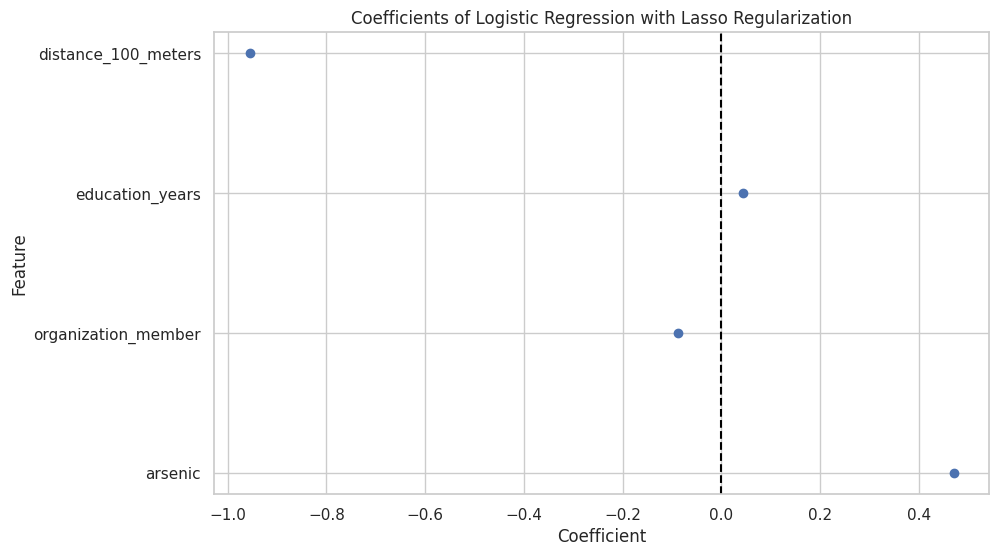

In [125]:
# fitting the logistic regression model with L1 penalty
log_reg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
log_reg_lasso.fit(X_train, y_train)

# extracting the coefficients and feature names
coefficients = log_reg_lasso.coef_.ravel()
feature_names = X_train.columns

# creating a df with coefficients and feature names
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# plotting scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(coef_df['Coefficient'], coef_df['Feature'])
plt.axvline(x=0, color='black', linestyle='--')
plt.ylabel('Feature')
plt.xlabel('Coefficient')
plt.title('Coefficients of Logistic Regression with Lasso Regularization')
plt.show()


In [121]:
# creating a LassoCV object with specified parameters
lassocv = LassoCV(alphas=None, cv=5, max_iter=100_000)

# fitting the LassoCV model to the training data
lassocv.fit(X_train, y_train)

lassocv.alpha_

0.00016388261479759653

The LassoCV model has determined that the best alpha value for the Lasso model is approximately 0.00016. This alpha value determines how strongly the Lasso model applies regularization. A smaller alpha means a stronger regularization, so we would say this is a strong model. 

In [119]:
lasso_reg = Lasso(alpha = lassocv.alpha_).fit(X_train, y_train)

In [120]:
# computing MSE, RMSE, and R-squared values 
MSE_lasso = mean_squared_error(y_test, lasso_reg.predict(X_test))
RMSE_lasso = np.sqrt(MSE_lasso)
R_squared_lasso = r2_score(y_test, lasso_reg.predict(X_test))

print('MSE =', MSE_lasso.round(3), ' RMSE =', RMSE_lasso.round(3), ' R-squared =', R_squared_lasso.round(3))

MSE = 0.235  RMSE = 0.485  R-squared = 0.04


MSE is 0.235 and RMSE is 0.485 which indicates a better fit due to it's lower values. While the r-sqaured value produced a lower number of 0.04. This could be largely due to not being able to capture underlying patterns and relationships in the data. 

In [126]:
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear')

lasso_log_reg.fit(X_train, y_train)

pred_lasso_log_reg = lasso_log_reg.predict(X_test)

print(classification_report(y_test, pred_lasso_log_reg, target_names=class_names))

              precision    recall  f1-score   support

   no switch       0.55      0.36      0.43       259
      switch       0.62      0.78      0.69       345

    accuracy                           0.60       604
   macro avg       0.58      0.57      0.56       604
weighted avg       0.59      0.60      0.58       604



This Lasso model achieved an accuracy of 60%. 



## Conclusion

To summarize our findings, we conducted an analysis using different machine learning models to predict households' behavior regarding well switching for drinking water. Here are the key points:

Model Performance:
* Overall, the models achieved an accuracy of around 60% in predicting well-switching behavior.
* Logistic regression, lasso regression, and ridge regression yielded similar results, indicating the significance of certain variables in determining switching decisions.
* The XGBoost model outperformed the other models with an accuracy of 62%.

Logistic Regression:
* Achieved 60% accuracy on the test data.
* Showed higher precision and recall for the "switch" class compared to the "not_switched" class.

Lasso Regression:
* Identified important variables such as arsenic levels, distance to the closest safe well, education years, and organization membership in predicting switching behavior.
* Achieved 60% accuracy, similar to logistic regression.

Ridge Regression:
* Produced results similar to logistic regression (60%) and lasso regression, highlighting the significance of the identified variables.

XGBoost:
* Demonstrated better performance with an accuracy of 62%.
* Showed higher precision and recall for the "switch" class, indicating its suitability for predicting well-switching behavior.

In conclusion, our analysis provides insights into the factors influencing households' decisions to switch wells for drinking water. These findings can contribute to understanding the dynamics of well-switching behavior and inform strategies for improving access to safe drinking water.